In [ ]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA
import librosa
import librosa.display
import torch

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Two speaker inputs - ICA computation

In [ ]:
signal1, sr1 = librosa.load('/content/speaker1.wav')
signal2, sr2 = librosa.load('/content/speaker2.wav')

In [ ]:
S = np.c_[signal1, signal2[0:13889972]]

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1], [0, 2]])
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(X)  # Reconstruct signals
S_ /= S_.std(axis=0)

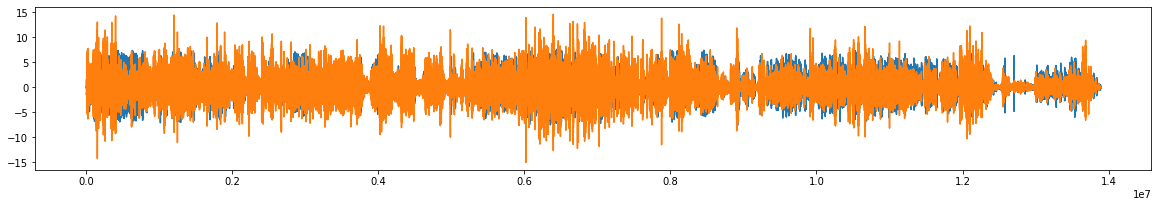

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(S)

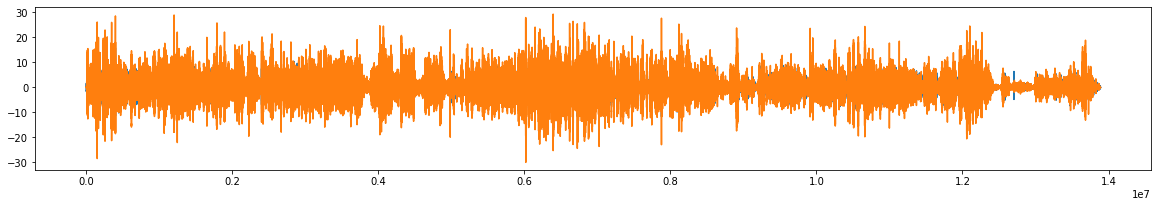

In [ ]:
plt.plot(X)

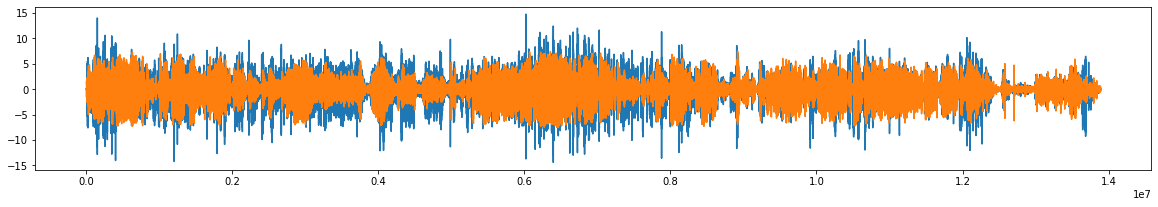

In [ ]:
plt.plot(range(len(S_)), S_)

# Speech Diarization

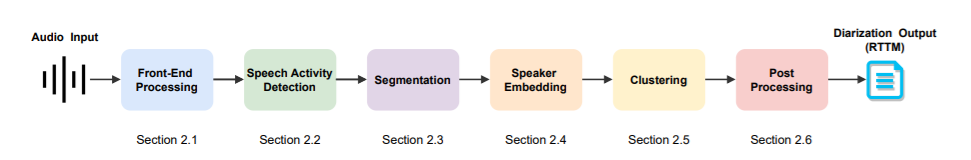

In [ ]:
ipd.Audio('/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav')

In [ ]:
# Install and restart local runtime: 
# ! pip install pyannote.core
# ! pip install pyannote.audio

pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia')
diarization = pipeline({'audio': '/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav'})
diarization

## VAD - Voice Activity Detection

In [ ]:
input, sr_input1 = librosa.load('/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav')
speaker1, sr1 = librosa.load('/content/drive/MyDrive/HDA Final Project/short_data/ground_truth_1.wav')
speaker2, sr2 = librosa.load('/content/drive/MyDrive/HDA Final Project/short_data/ground_truth_2.wav')

### CNN Based VAD

In [ ]:
# CNN-based audio segmentation toolkit

! pip install inaSpeechSegmenter
from inaSpeechSegmenter import Segmenter

seg = Segmenter()
segmentation = seg('/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav')

In [ ]:
print(segmentation)

[('noEnergy', 0.0, 0.22), ('noise', 0.22, 3.0), ('male', 3.0, 6.98), ('female', 6.98, 8.700000000000001), ('noise', 8.700000000000001, 44.28), ('music', 44.28, 47.0), ('noise', 47.0, 81.72), ('music', 81.72, 86.66), ('noise', 86.66, 96.4), ('music', 96.4, 99.72), ('noise', 99.72, 131.84)]


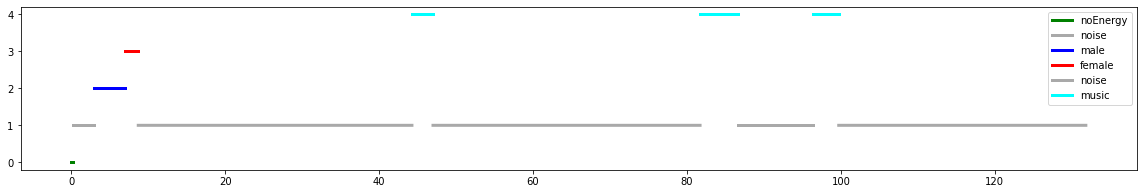

In [ ]:
classes = ['noEnergy', 'noise', 'male', 'female', 'music']
colors = ['green', 'darkgray', 'blue', 'red', 'cyan']
plt.rcParams["figure.figsize"] = (20,3)

for s in segmentation:
  color_class = classes.index(s[0])
  plt.plot(np.arange(s[1], s[2] - 0.01, 0.01), np.repeat(color_class, len(np.arange(s[1], s[2] - 0.01, 0.01))), lw=3, c=colors[color_class],
           label=s[0] if segmentation.index(s) <= 5 else "")
  plt.legend()

plt.show()

### Energy based VAD

In [ ]:
# VAD based on ration between energy in speech band and total energy.

# Algorithm description: 

# Convert stereo to mono.
# Move a window of 20ms along the audio data.
# Calculate the ratio between energy of speech band and total energy for window.
# If ratio is more than threshold (0.6 by default) label windows as speech.
# Apply median filter with length of 0.5s to smooth detected speech regions.
# Represent speech regions as intervals of time.

! wget https://raw.githubusercontent.com/marsbroshok/VAD-python/master/vad.py

from vad import VoiceActivityDetector

filename = '/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav'
v = VoiceActivityDetector(filename)

--2022-02-18 04:34:35--  https://raw.githubusercontent.com/marsbroshok/VAD-python/master/vad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6589 (6.4K) [text/plain]
Saving to: ‘vad.py.1’

vad.py.1            100%[===================>]   6.43K  --.-KB/s    in 0s      

2022-02-18 04:34:35 (39.3 MB/s) - ‘vad.py.1’ saved [6589/6589]



/content/vad.py:149: RuntimeWarning: invalid value encountered in double_scalars
  speech_ratio = sum_voice_energy/sum_full_energy


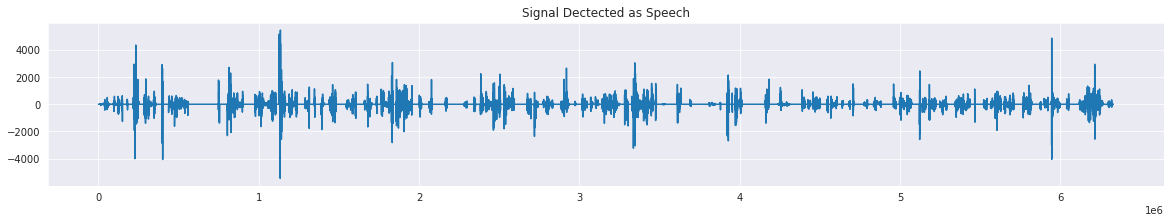

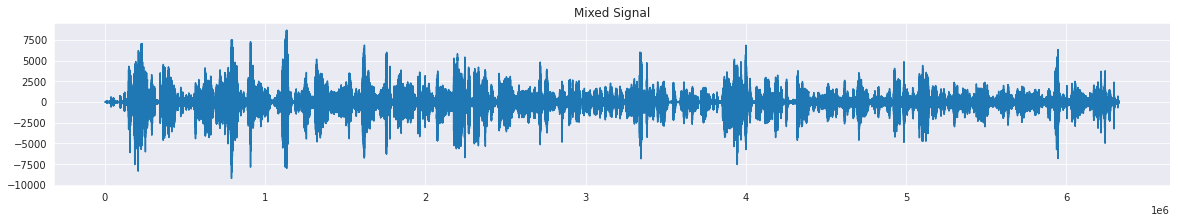

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

data = v.data
detected_windows = v.detect_speech()
data_speech = np.zeros(len(data))
it = np.nditer(detected_windows[:,0], flags=['f_index'])
while not it.finished:
  data_speech[int(it[0])] = data[int(it[0])] * detected_windows[it.index,1]
  it.iternext()

plt.figure()
plt.plot(data_speech)
plt.title('Signal Dectected as Speech')
plt.show()
plt.plot(data)
plt.title('Mixed Signal')
plt.show()

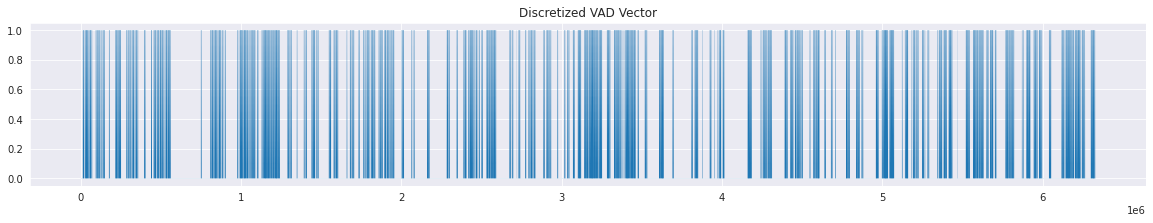

In [ ]:
speech_data = [1 if s > 0 else 0 for s in data_speech]
plt.plot(speech_data, lw=0.1)
plt.title('Discretized VAD Vector')
plt.show()

### Ground truth generation

In [ ]:
# GT 1 is the minimum

input = input[:len(speaker1)]
speaker2 = speaker2[:len(speaker1)]

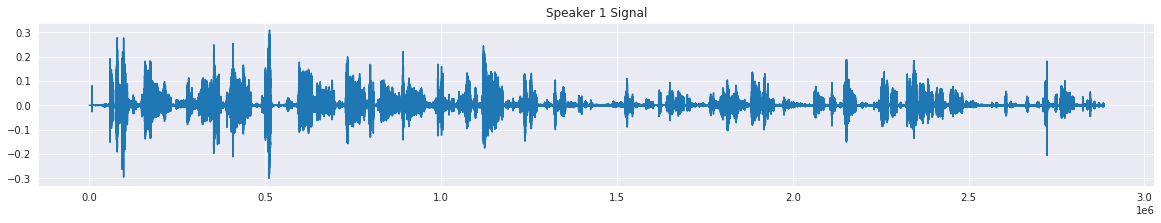

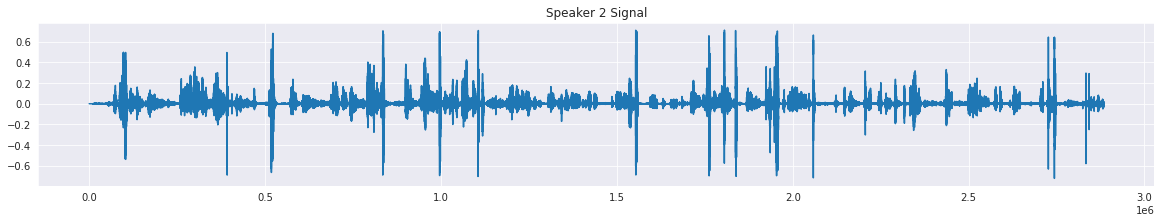

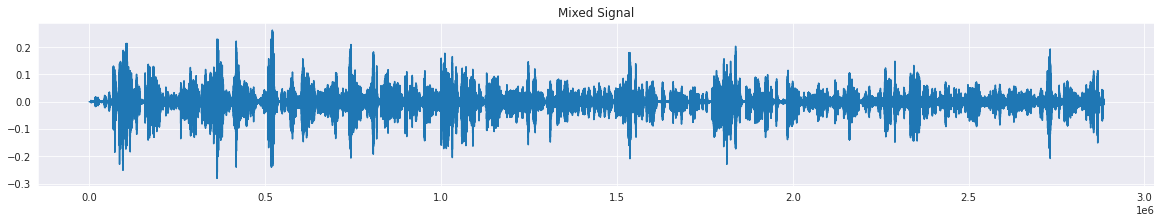

In [ ]:
# Display of signals for: SPEAKER 1; SPEAKER 2; MIXED RECORDING
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(speaker1)
plt.title('Speaker 1 Signal')
plt.show()
plt.title('Speaker 2 Signal')
plt.plot(speaker2)
plt.show()
plt.title('Mixed Signal')
plt.plot(input)
plt.show()

In [ ]:
# ! pip install noisereduce
import noisereduce as nr

# Threshold values are chosen empirically (to reduce the presence of the other speaker)
threshold_1 = [s if s > 0.015 or s < -0.015 else 0 for s in speaker1]
threshold_2 = [s if s > 0.025 or s < -0.025 else 0 for s in speaker2]

# Noise is generated from the direct apmplitude thresholding
reduced_noise_1 = nr.reduce_noise(y=threshold_1, sr=sr1)
reduced_noise_2 = nr.reduce_noise(y=threshold_2, sr=sr1)

# Mean function has shown empirically to keep the shape of the signal
# with better precision than resampling alternatives (scipy.signal.resample)
speech_data_resampled = [np.mean(block) for block in np.array_split(speech_data, len(reduced_noise_1))]
speech_data_discretized = [1 if x != 0 else 0 for x in speech_data_resampled]

# Generation of a 0 / 1 Voice Activity Vector
gt1_discretized = [1 if x != 0 else 0 for x in reduced_noise_1]
gt2_discretized = [1 if x != 0 else 0 for x in reduced_noise_2]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

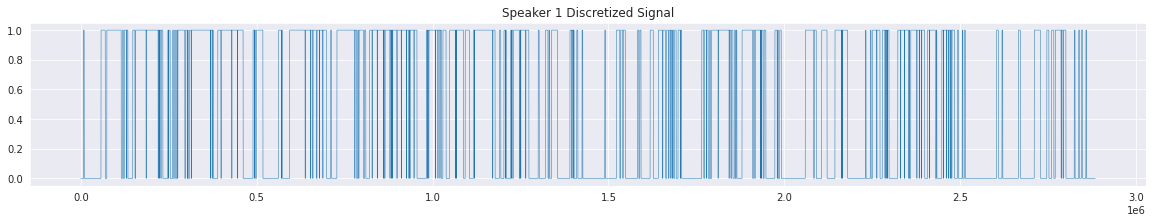

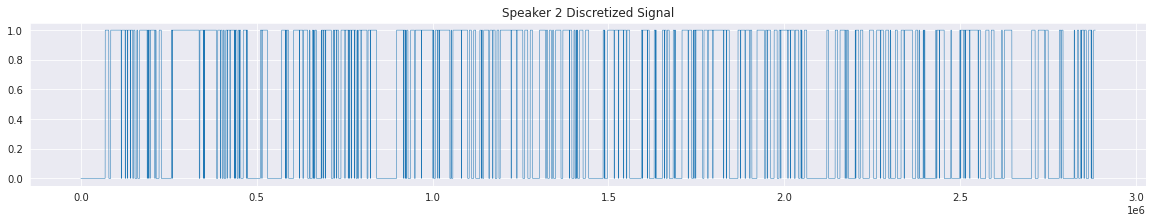

In [ ]:
plt.plot(gt1_discretized, lw = 0.5)
plt.title('Speaker 1 Discretized Signal')
plt.show()
plt.plot(gt2_discretized, lw= 0.5)
plt.title('Speaker 2 Discretized Signal')
plt.show()

Text(0.5, 1.0, 'Mixed Ground Truth Voice Activity Vector')

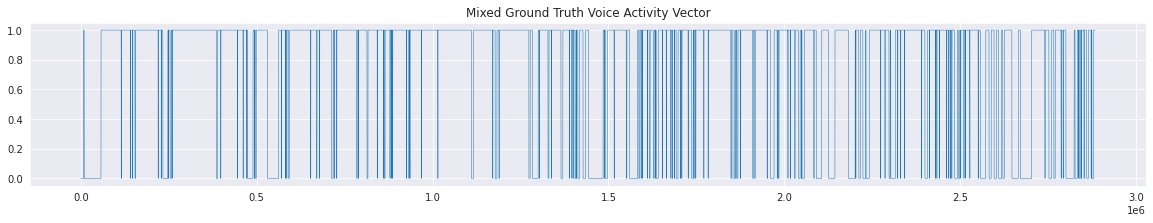

In [ ]:
# Ground truth voice activity vector

silence_vector = []
for i in zip(gt1_discretized, gt2_discretized):
  if i[0] == 1 or i[1] == 1:
    silence_vector.append(1)
  else:
    silence_vector.append(0)
  
plt.plot(range(len(silence_vector)), silence_vector, lw = 0.5)
plt.title('Mixed Ground Truth Voice Activity Vector')

In [ ]:
print('Percentage of true voice activity: ' + str(sum(silence_vector) / len(silence_vector) * 100))

Percentage of true voice activity: 77.84317859044914


In [ ]:
# Accuracy computation

acc = 0
for i in range(len(speech_data_discretized)):
  if speech_data_discretized[i] == silence_vector[i]:
    acc += 1
  
print("Overlap between vectors: voice activity detection accuracy: " + str(acc / len(silence_vector)))

Overlap between vectors: voice activity detection accuracy: 0.22211777971329663


In [ ]:
# Alternative Sampling -  2 samples per second

# Variable to change sampling rate 
samples_per_second = 2

gt1_persecond = [np.mean(block) for block in np.array_split(reduced_noise_1, int(len(reduced_noise_1) / sr1) * samples_per_second)]
gt2_persecond = [np.mean(block) for block in np.array_split(reduced_noise_2, int(len(reduced_noise_2) / sr2) * samples_per_second)]
gt1_discretized = [1 if x != 0 else 0 for x in gt1_persecond]
gt2_discretized = [1 if x != 0 else 0 for x in gt2_persecond]

silence_vector = []
for i in zip(gt1_discretized, gt2_discretized):
  if i[0] == 1 or i[1] == 1:
    silence_vector.append(1)
  else:
    silence_vector.append(0)

speech_data_resampled = [np.mean(block) for block in np.array_split(speech_data, len(silence_vector))]
speech_data_discretized = [1 if x != 0 else 0 for x in speech_data_resampled]

acc = 0
for i in range(len(speech_data_discretized)):
  if speech_data_discretized[i] == silence_vector[i]:
    acc += 1

print("Overlap between vectors: voice activity detection accuracy: " + str(acc / len(silence_vector)))

Overlap between vectors: voice activity detection accuracy: 0.6923076923076923


### Inference on RNN trained VAD

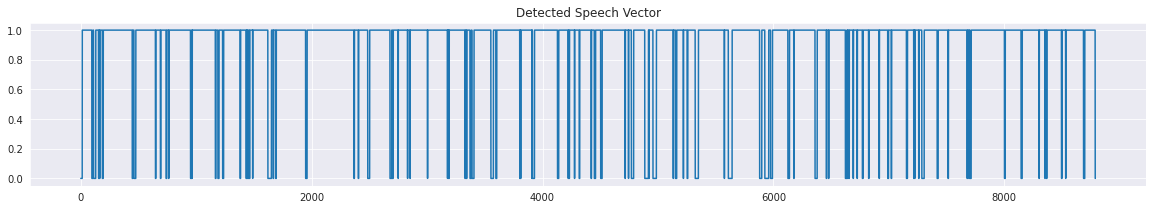

In [ ]:
! pip install webrtcvad

import collections
import contextlib
import sys
import wave
import webrtcvad

def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 2
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate

def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(2)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)

class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.
    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.
    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.
    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.
    Arguments:
    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).
    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])

audio, sample_rate = read_wave('/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav')
vad = webrtcvad.Vad(1)

# Can only hande frames of 10, 20 oe 30ms
frames = frame_generator(30, audio, sample_rate)
frames = list(frames)

speech_vector = []
for frame in frames:
  speech_vector.append(vad.is_speech(frame.bytes, sample_rate))

plt.plot(speech_vector)
plt.title('Detected Speech Vector')
plt.show()

In [ ]:
# Compute accuracy - 0.5 samples per second

arr = [np.mean(block) for block in np.array_split(speech_vector, len(silence_vector))]
arr = [1 if a > 0 else 0 for a in arr]

# Accuracy computation

acc = 0
for i in range(len(arr)):
  if arr[i] == silence_vector[i]:
    acc += 1
  
print(acc / len(silence_vector))

0.9346153846153846


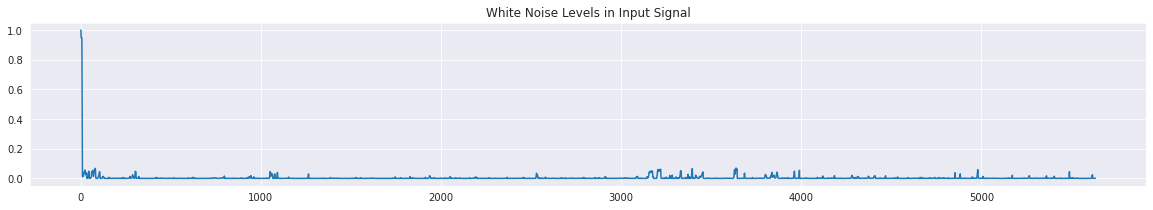

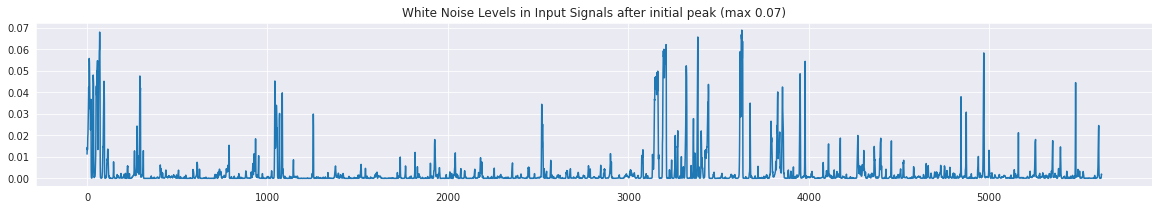

In [ ]:
# Calculate noise level
# Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to being tone-like

noise = librosa.feature.spectral_flatness(y=input)
plt.plot(noise[0])
plt.title('White Noise Levels in Input Signal')
plt.show()

plt.plot(noise[0][10:])
plt.title('White Noise Levels in Input Signals after initial peak (max 0.07)')
plt.show()

In [ ]:
# Because of high accuracy of VAD we remove the silence frames for the upcoming step of clustring

signal_updated = np.array([item for x, s_vec in zip(np.array_split(input, len(speech_vector)), speech_vector) if s_vec == 1 for item in x])

# Update gt for misclassification error

gt1_updated = np.array([item for x, s_vec in zip(np.array_split(reduced_noise_1, len(speech_vector)), speech_vector) if s_vec == 1 for item in x])
gt2_updated = np.array([item for x, s_vec in zip(np.array_split(reduced_noise_2, len(speech_vector)), speech_vector) if s_vec == 1 for item in x])

gt1_persecond_updated = [np.mean(block) for block in np.array_split(gt1_updated, int(len(gt1_updated) / sr1 + 1) * samples_per_second)]
gt2_persecond_updated = [np.mean(block) for block in np.array_split(gt2_updated, int(len(gt1_updated) / sr2 + 1) * samples_per_second)]

gt1_persecond_updated = [1 if x != 0 else 0 for x in gt1_persecond_updated]
gt2_persecond_updated = [1 if x != 0 else 0 for x in gt2_persecond_updated]

## Overlap detection

In [ ]:

print('Percentage of ground truth overlap: ' + str(sum([1  if gt1 != 0 and gt2 != 0 else 0 for gt1, gt2 in
                                                        zip(gt1_updated, gt2_updated)]) / len(gt1_updated) * 100))

Percentage of ground truth overlap: 33.161697178906174


In [ ]:
import torch

overlap_detection = torch.hub.load('pyannote/pyannote-audio', 'ovl_ami', pipeline=True)
timeline = overlap_detection({'audio': '/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav'}).get_timeline()

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


  0%|          | 0.00/2.41M [00:00<?, ?B/s]

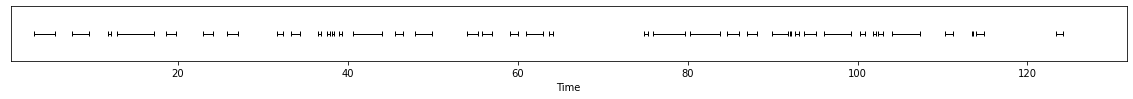

In [ ]:
timeline

In [ ]:
# Calculate ground truth overlap
gt_overlap = [1 if (gt1 != 0 and gt2 != 0) else 0 for gt1, gt2 in zip(reduced_noise_1, reduced_noise_2)]

# Resample to audio length * 100 to facilitate accuracy computation 
gt_overlap = [np.mean(block) for block in np.array_split(gt_overlap, len(reduced_noise_1) / sr1 * 100)]
gt_overlap = [1 if a != 0 else 0 for a in gt_overlap]

In [ ]:
# Compute accuracy

acc = 0
for segment in timeline:
  start = int(round(segment.start, 2) * 100)
  end = int(round(segment.end, 2) * 100)
  for index in range(start, end):
    if(gt_overlap[index] == 1):
      acc += 1

print("Overlap Accuracy : " + str(acc / len(gt_overlap)))

Overlap Accuracy : 0.19611591100237022


## Feature Embeddings
Sampled once or twice per second: the current ground truth is set to 2 samples per second

In [ ]:
! pip install resemblyzer

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
from pathlib import Path

encoder = VoiceEncoder("cpu")

# 0.5 seconds: rate = 1.455
# 1 second: rate = 0.73

embed, partial_embed, wav_slices = encoder.embed_utterance(signal_updated, return_partials=True, rate=1.48)
print(partial_embed.shape)

Loaded the voice encoder model on cpu in 0.01 seconds.
(238, 256)


In [ ]:
# Extract mfcc coefficients

# Hop size = sr_input1 for sampling every second
mfccs = librosa.feature.mfcc(y=signal_updated, n_mfcc=12, sr=sr_input1, hop_length=int(sr_input1/2))

# Extract energy
energy = librosa.feature.rms(y=signal_updated, hop_length=int(sr_input1/2))

# First derivative of coefficients and energy

delta_mfccs = librosa.feature.delta(mfccs)
delta_energy = librosa.feature.delta(energy)

# Second order of coefficients and energy

delta2_mfccs = librosa.feature.delta(mfccs, order=2)
delta2_energy = librosa.feature.delta(energy, order=2)

# Create features
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs, energy, delta_energy, delta2_energy))
print(mfccs_features.shape)

(39, 236)


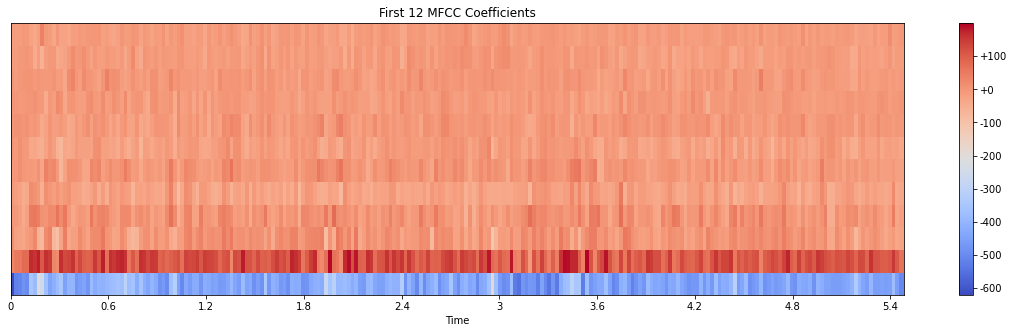

In [ ]:
# Visualisation of MFCCs

plt.figure(figsize=(20, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr_input1)
plt.colorbar(format="%+2.f")
plt.title('First 12 MFCC Coefficients')
plt.show()

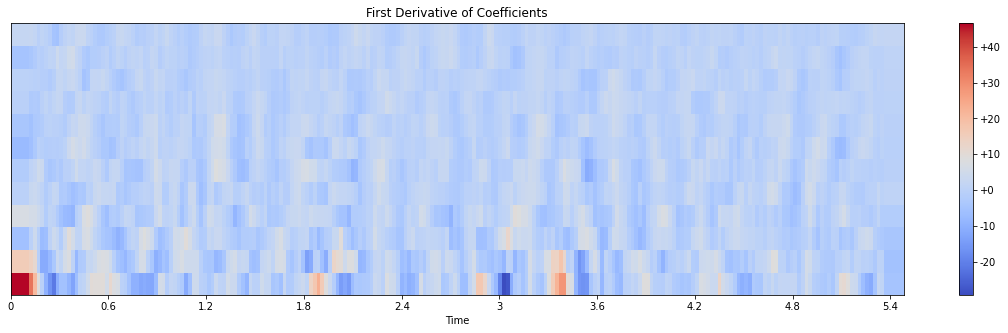

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr_input1)
plt.colorbar(format="%+2.f")
plt.title('First Derivative of Coefficients')
plt.show()

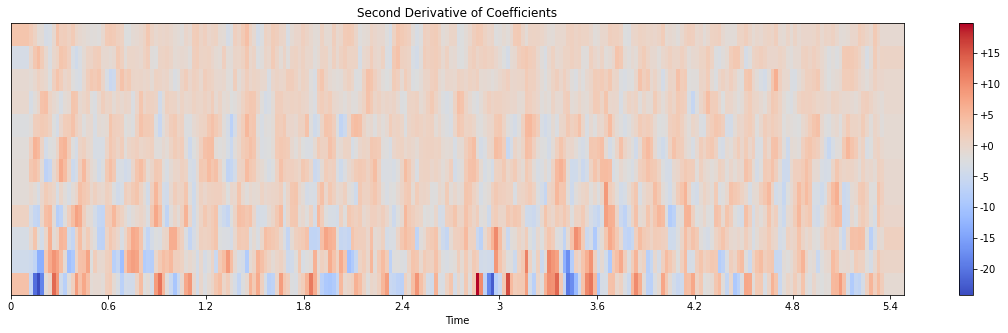

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sr_input1)
plt.colorbar(format="%+2.f")
plt.title('Second Derivative of Coefficients')
plt.show()

## Clustering

Spectral clustering, Kmeans clustering, GMM clustering, HDBSCAN, DBSCAN

In [ ]:
!pip3 install spectralcluster
from spectralcluster import SpectralClusterer

clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=10,
    autotune=None,
    laplacian_type=None,
    refinement_options=None,
    custom_dist="cosine")

# Select features
#labels = clusterer.predict(mfccs_features.T)
labels = clusterer.predict(partial_embed)

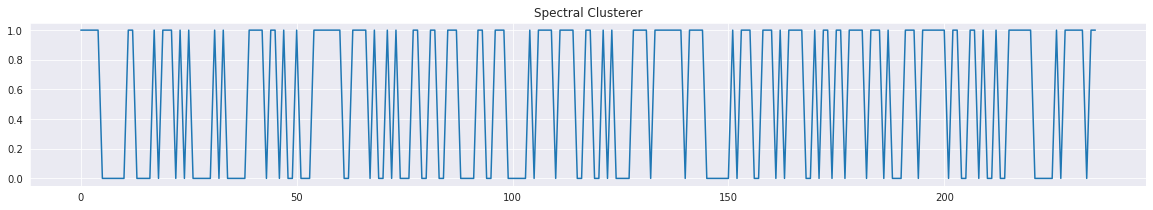

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(labels)
plt.title('Spectral Clusterer')
plt.show()

In [ ]:
# Permutation invariant accuracy for no overlap clustering
### Hungarian algorithm for permutation invariance ###

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] == labels[i]) and (gt2_persecond_updated[i] != labels[i]):
    acc += 1

print((acc / len(gt1_persecond_updated)) * 100)

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] != labels[i]) and (gt2_persecond_updated[i] == labels[i]):
    acc += 1

print((acc / len(gt1_persecond_updated)) * 100)

8.898305084745763
16.101694915254235


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(mfccs_features.T)

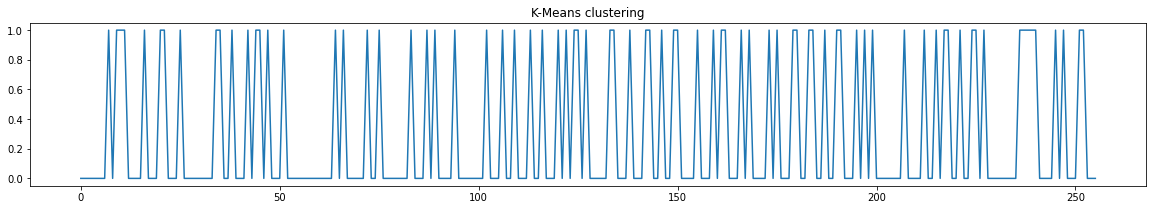

In [ ]:
plt.plot(kmeans.labels_)
plt.title('K-Means clustering')
plt.show()

In [ ]:
# Permutation invariant accuracy for 2 clusters

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] == kmeans.labels_[i]) and (gt2_persecond_updated[i] != kmeans.labels_[i]):
    acc += 1

print((acc / len(gt1_persecond_updated)) * 100)

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] != kmeans.labels_[i]) and (gt2_persecond_updated[i] == kmeans.labels_[i]):
    acc += 1
    
print((acc / len(gt1_persecond_updated)) * 100)

12.288135593220339
12.711864406779661


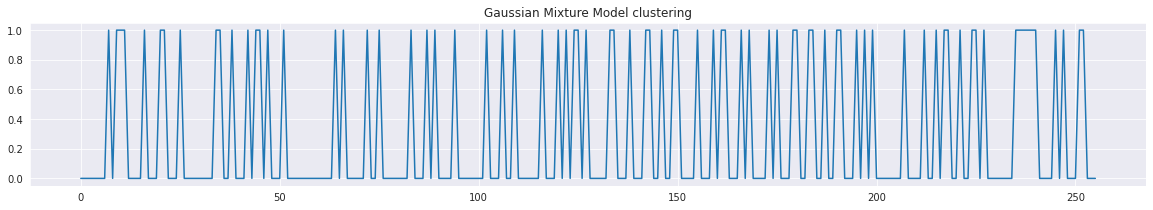

In [ ]:
from sklearn import mixture

g = mixture.GaussianMixture(n_components=2)
g.fit(partial_embed.T)

gmm_labels = g.predict(partial_embed.T)
plt.plot(gmm_labels)
plt.title('Gaussian Mixture Model clustering')
plt.show()

In [ ]:
# Permutation invariant accuracy for 2 clusters

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] == gmm_labels[i]) and (gt2_persecond_updated[i] != gmm_labels[i]):
    acc += 1

print((acc / len(gt1_persecond_updated)) * 100)

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] != gmm_labels[i]) and (gt2_persecond_updated[i] == gmm_labels[i]):
    acc += 1
    
print((acc / len(gt1_persecond_updated)) * 100)

13.983050847457626
11.016949152542372


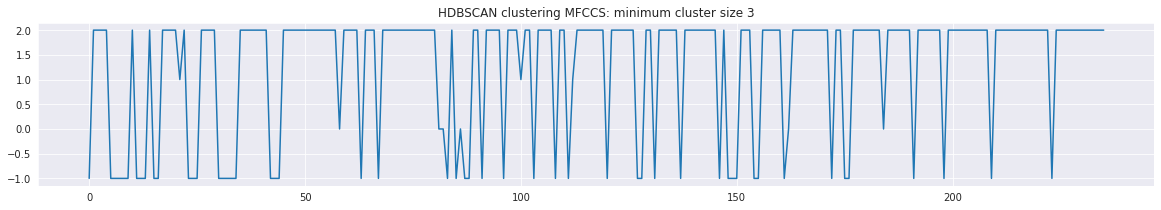

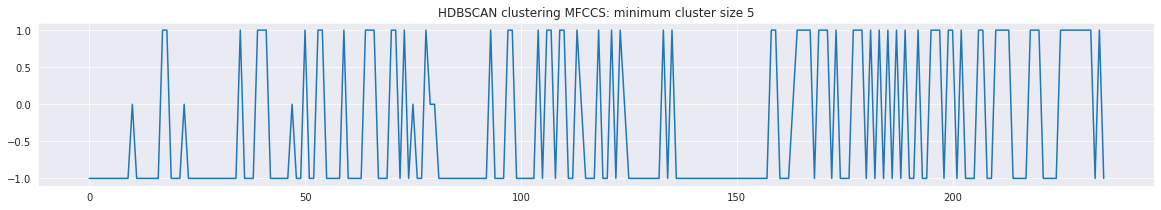

In [ ]:
# Soft clustering to include overlaps with HDBSCAN
# ! pip install hdbscan --no-cache-dir --no-binary :all:

import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, prediction_data=True).fit(mfccs_features.T)
plt.plot(clusterer.labels_)
plt.title('HDBSCAN clustering MFCCS: minimum cluster size 3')
plt.show()

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True).fit(mfccs_features.T)
plt.plot(clusterer.labels_)
plt.title('HDBSCAN clustering MFCCS: minimum cluster size 5')
plt.show()

In [ ]:
# Accuracy with the assumption of overlap class = 0

acc = 0
for i in range(len(gt1_persecond_updated)):
  if (clusterer.probabilities_[i] > 0.5):
    if(gt1_persecond_updated[i] == 1 and clusterer.labels_[i] == -1.0):
      acc += 1
    if(gt2_persecond_updated[i] == 0 and clusterer.labels_[i] == 1):
      acc += 1

print((acc / len(gt1_persecond_updated)) * 100)

acc = 0
for i in range(len(gt1_persecond_updated)):
  if (clusterer.probabilities_[i] > 0.5):
    if(gt1_persecond_updated[i] == 1 and clusterer.labels_[i] == 1):
      acc += 1
    if(gt2_persecond_updated[i] == 0 and clusterer.labels_[i] == -1.0):
      acc += 1
    
print((acc / len(gt1_persecond_updated)) * 100)

0.0
0.0


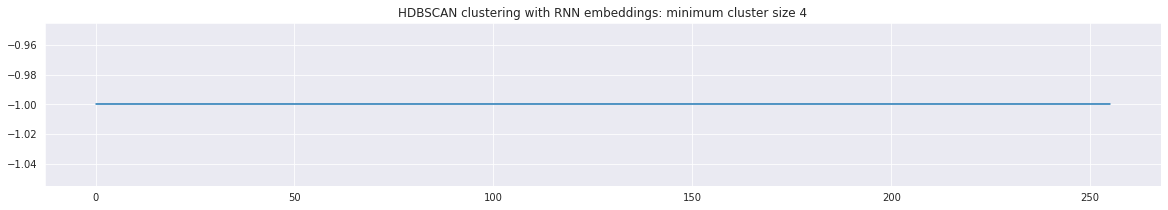

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, prediction_data=True).fit(partial_embed.T)
plt.plot(clusterer.labels_)
plt.title('HDBSCAN clustering with RNN embeddings: minimum cluster size 4')
plt.show()

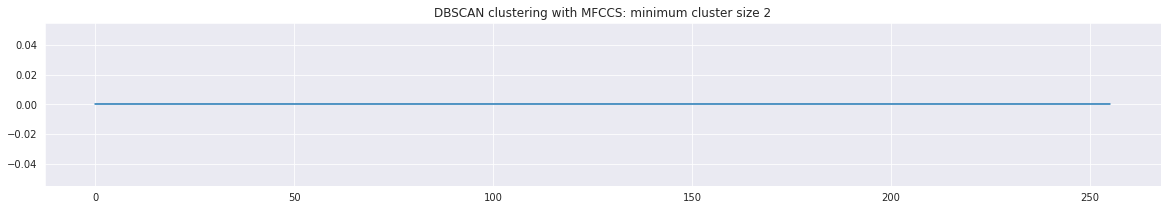

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=2).fit(partial_embed.T)
plt.plot(clustering.labels_)
plt.title('DBSCAN clustering with MFCCS: minimum cluster size 2')
plt.show()

In [ ]:
# Accuracy with the assumption of overlap class = 0

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] == clustering.labels_[i]) and (gt2_persecond_updated[i] != clustering.labels_[i]):
    acc += 1

print((acc / len(gt1_persecond_updated)) * 100)

acc = 0
for i in range(len(gt1_persecond_updated)):
  if(gt1_persecond_updated[i] != clustering.labels_[i]) and (gt2_persecond_updated[i] == clustering.labels_[i]):
    acc += 1
    
print((acc / len(gt1_persecond_updated)) * 100)

0.0
0.0


# End to End training

In [ ]:
# Data Loading

input_part1, sr_input1 = librosa.load("/content/drive/MyDrive/HDA Final Project/Recording1.wav")
input_part2, sr_input2 = librosa.load("/content/drive/MyDrive/HDA Final Project/Recording2.wav") 

# Ground truth

speaker_1_1, sr_speaker_1_1 = librosa.load("/content/drive/MyDrive/HDA Final Project/speaker1_1.wav")
speaker_1_2, sr_speaker_1_2 = librosa.load("/content/drive/MyDrive/HDA Final Project/speaker1_2.wav")

speaker_2_1, sr_speaker_2_1 = librosa.load("/content/drive/MyDrive/HDA Final Project/speaker2_1.wav")
speaker_2_2, sr_speaker_2_2 = librosa.load("/content/drive/MyDrive/HDA Final Project/speaker2_2.wav")

# Trimming ends (recordings have started in the same time)

input_part1 = input_part1[:len(speaker_1_1)]
speaker_2_1 = speaker_2_1[:len(speaker_1_1)]

speaker_1_2 = speaker_1_2[:len(input_part2)]
speaker_2_2 = speaker_2_2[:len(input_part2)]

In [ ]:
print(sr_input1 == sr_input2 == sr_speaker_1_1 == sr_speaker_1_2 == sr_speaker_2_1 == sr_speaker_2_2)

True


In [ ]:
# Input data alternatives

# input = np.append(input_part1, input_part2)
# speaker1 = np.append(speaker_1_1, speaker_1_2)
#speaker2 = np.append(speaker_2_1, speaker_2_2)

input, sr_input1 = librosa.load('/content/drive/MyDrive/HDA Final Project/short_data/Recording.wav')
speaker1, sr1 = librosa.load('/content/drive/MyDrive/HDA Final Project/short_data/ground_truth_1.wav')
speaker2, sr2 = librosa.load('/content/drive/MyDrive/HDA Final Project/short_data/ground_truth_2.wav')

In [ ]:
input = input[:len(speaker1)]
speaker2 = speaker2[:len(speaker2)]

In [ ]:
# Extract features

! pip install speechpy
import speechpy

features = speechpy.feature.lmfe(input,
                                 sr_input1,
                                 frame_length=0.025,
                                 frame_stride=0.01,
                                 num_filters=23,
                                 fft_length=512,
                                 low_frequency=0,
                                 high_frequency=None)

print(features.shape)

(13107, 23)


In [ ]:
# MFCCS Features

# Extract mfcc coefficients

mfccs = librosa.feature.mfcc(y=input, n_mfcc=12, sr=sr_input1)

# Extract energy
energy = librosa.feature.rms(y=input)

# First derivative of coefficients and energy

delta_mfccs = librosa.feature.delta(mfccs)
delta_energy = librosa.feature.delta(energy)

# Second order of coefficients and energy

delta2_mfccs = librosa.feature.delta(mfccs, order=2)
delta2_energy = librosa.feature.delta(energy, order=2)

# Create features
features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs, energy, delta_energy, delta2_energy)).T
print(features.shape)

(84715, 39)


In [ ]:
# SFT Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

ps = librosa.feature.melspectrogram(y=input, sr=sr_input1)

# Selected 120 because of high correlation
features = librosa.power_to_db(ps, ref=np.max)[:120].T

features = scaler.fit(features).transform(features)

print(features.shape)

(5634, 120)


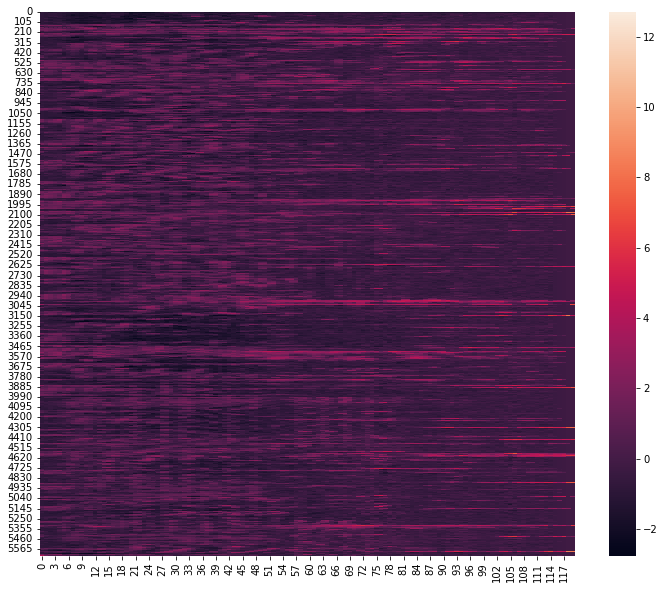

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (12,10)
sns.heatmap(features)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'SFT Correlation')

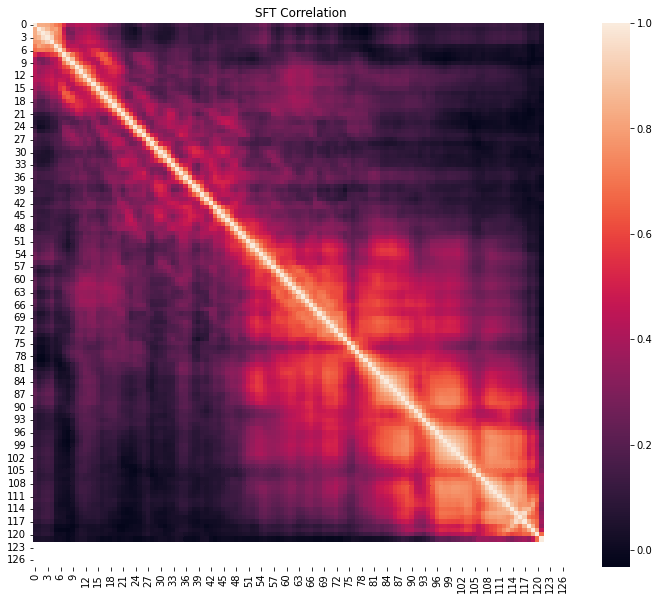

In [ ]:
corr = np.corrcoef(features.T)
sns.heatmap(corr)
plt.title('SFT Correlation')


In [ ]:
# Windowing

before_window = 3
after_window = 4

windowed_features = []
for i in range(before_window):
    features = np.append([np.zeros((features[0].shape))], features, axis=0)

for i in range(after_window):
    features = np.append(features, [np.zeros((features[0].shape))], axis=0)

for i in range(before_window, len(features) - after_window):
  windowed_features.append(features[i-before_window : i+after_window])

windowed_features = np.array(windowed_features)
print(windowed_features.shape)

(5634, 7, 120)


In [ ]:
# Create ground truth
#! pip install noisereduce
import noisereduce as nr

gt = np.zeros((windowed_features.shape[0], 4))

threshold_1 = [s if s > 0.015 or s < -0.015 else 0 for s in speaker1]
threshold_2 = [s if s > 0.025 or s < -0.025 else 0 for s in speaker2]

reduced_noise_1 = nr.reduce_noise(y=threshold_1, sr=sr_input1)
reduced_noise_2 = nr.reduce_noise(y=threshold_2, sr=sr_input1)

speaker1_framed = [np.mean(x) for x in np.array_split(reduced_noise_1, len(windowed_features))]
speaker2_framed = [np.mean(x) for x in np.array_split(reduced_noise_2, len(windowed_features))]

for i in range(len(windowed_features)):
  if speaker1_framed[i] == 0 and speaker2_framed[i] == 0: gt[i][0] = 1
  elif speaker1_framed[i] != 0 and speaker2_framed[i] == 0: gt[i][1] = 1
  elif speaker1_framed[i] == 0 and speaker2_framed[i] != 0: gt[i][2] = 1
  else:
    gt[i][3] = 1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Print class balance

print("Silence: " + str(sum([1 if i[0] == 1 else 0 for i in gt]) / len(gt) * 100))
print("Speaker 1: " + str(sum([1 if i[1] == 1 else 0 for i in gt]) / len(gt) * 100))
print("Speaker 2: " + str(sum([1 if i[2] == 1 else 0 for i in gt]) / len(gt) * 100 ))
print("Overlap: " + str(sum([1 if i[3] == 1 else 0 for i in gt]) / len(gt) * 100))

Silence: 21.972991531242847
Speaker 1: 19.111924925612268
Speaker 2: 24.803540093080034
Overlap: 34.11154345006485


In [ ]:
# Introduce permutations in data

append_features = []
append_gt = []
for i in range(len(windowed_features)):
  if gt[i][1] == 1:
    append_features.append(windowed_features[i])
    append_gt.append([0, 0, 1, 0])

  if gt[i][2] == 1:
    append_features.append(windowed_features[i])
    append_gt.append([0, 1, 0, 0])

windowed_features = np.append(windowed_features, append_features, axis = 0)
gt = np.append(gt, append_gt, axis = 0)

print(windowed_features.shape)
print(gt.shape)

(8069, 7, 120)
(8069, 4)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(windowed_features, gt, stratify=gt, test_size=0.20, random_state=42)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

arr = np.array([0, 1, 2, 3])
labels = [0 if s[0] == 1 else 1 if s[1] == 1 else 2 if s[2] == 1 else 3 for s in gt]
weights = compute_class_weight('balanced', classes = arr, y = labels)
print(weights)

[1.20384615 1.33128544 1.02287582 0.69418433]


In [ ]:
# Implement Diarization error

import keras

class Metrics(keras.callbacks.Callback):

    def __init__(self, val_data, batch_size = 10):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size

    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        der, der_without_overlap = 0, 0

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        for i in range(len(y_val)):

          # False Alarm of Speech
          if y_val[i] == 0 and y_predict[i] != 0:
            der += 1
            der_without_overlap += 1

          # Missed Detection of speech
          if (y_val[i] != 0) and y_predict[i] == 0:
            der += 1
            der_without_overlap += 1

          # Overlap detection
          if y_val[i] == 3 and y_predict[i] != 3:
            der += 1

          # Speaker Confusion
          if (y_val[i] == 1 and y_predict[i] == 2) or (y_val[i] == 2 and y_predict[i] == 1):
            der += 1
            der_without_overlap += 1

        der = der / len(y_val) if der > 0 else 0
        der_without_overlap = der_without_overlap / len(y_val) if der_without_overlap > 0 else 0

        self._data.append({
            'der': der,
            'der_without_overlap': der_without_overlap,
        })

        return

    def get_data(self):
        return self._data

In [ ]:
# Create proposed model
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), input_shape=(windowed_features.shape[1:])))
model.add(tf.keras.layers.BatchNormalization())

# Reduce / Expand model
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [ ]:
metrics = Metrics(val_data=(X_test, y_test))

model.compile(loss='categorical_crossentropy', optimizer='adam', loss_weights=weights, metrics=["acc", "mse"])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_test, y_test), callbacks=[metrics])

Epoch 1/30
36/36 [==============================] - 22s 384ms/step - loss: 1.3898 - acc: 0.4615 - mse: 0.1724 - val_loss: 1.2920 - val_acc: 0.5608 - val_mse: 0.1646
Epoch 2/30
36/36 [==============================] - 10s 276ms/step - loss: 0.9992 - acc: 0.6075 - mse: 0.1276 - val_loss: 1.1422 - val_acc: 0.6513 - val_mse: 0.1450
Epoch 3/30
36/36 [==============================] - 11s 293ms/step - loss: 0.7891 - acc: 0.7047 - mse: 0.1010 - val_loss: 0.9630 - val_acc: 0.7090 - val_mse: 0.1207
Epoch 4/30
36/36 [==============================] - 10s 276ms/step - loss: 0.6868 - acc: 0.7493 - mse: 0.0872 - val_loss: 0.7932 - val_acc: 0.7746 - val_mse: 0.0981
Epoch 5/30
36/36 [==============================] - 11s 299ms/step - loss: 0.5479 - acc: 0.8112 - mse: 0.0690 - val_loss: 0.6101 - val_acc: 0.8190 - val_mse: 0.0745
Epoch 6/30
36/36 [==============================] - 10s 277ms/step - loss: 0.4801 - acc: 0.8365 - mse: 0.0593 - val_loss: 0.5328 - val_acc: 0.8243 - val_mse: 0.0654
Epoch 7/30

In [ ]:
der_metrics = metrics.get_data()

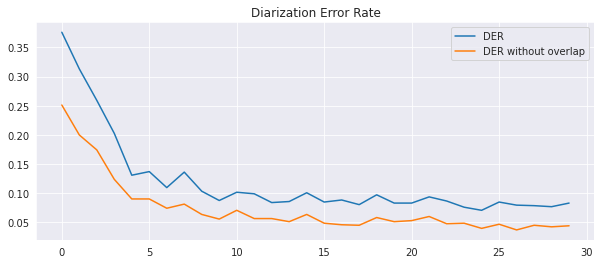

In [ ]:
sns.set_style('darkgrid')

plt.rcParams["figure.figsize"] = (10,4)
plt.plot([item['der'] for item in der_metrics], label='DER')
plt.plot([item['der_without_overlap'] for item in der_metrics], label='DER without overlap')
plt.title('Diarization Error Rate')
plt.legend()
plt.savefig('/content/drive/MyDrive/HDA Final Project/der.pdf')
plt.show()

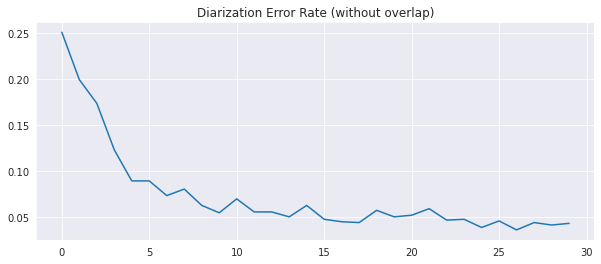

In [ ]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot([item['der_without_overlap'] for item in der_metrics])
plt.title('Diarization Error Rate (without overlap)')
plt.savefig('/content/drive/MyDrive/HDA Final Project/der.eps')
plt.show()

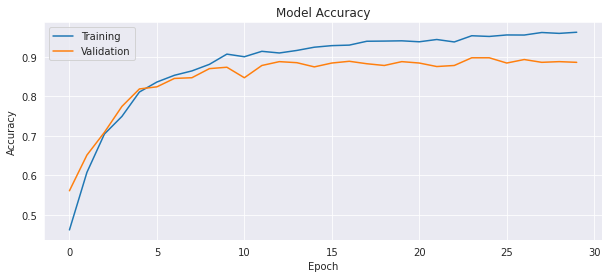

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
# plt.savefig('/content/drive/MyDrive/HDA Final Project/5-blstm-acc.eps')
plt.show()

In [ ]:
from sklearn import metrics

true = np.argmax(y_test, axis=1)
test = np.argmax(model.predict(X_test), axis=1)

metrics.precision_recall_fscore_support(true, test)

(array([0.9122807 , 0.83035714, 0.88043478, 0.90726817]),
 array([0.88888889, 0.87735849, 0.88363636, 0.89162562]),
 array([0.9004329 , 0.85321101, 0.88203267, 0.89937888]),
 array([234, 212, 275, 406]))

In [ ]:
print(der_metrics[-1])
metrics.f1_score(true, test, average='macro')

{'der': 0.08251996450754215, 'der_without_overlap': 0.043478260869565216}


0.8837638648678445

Text(0.5, 1.0, 'Confusion Matrix')

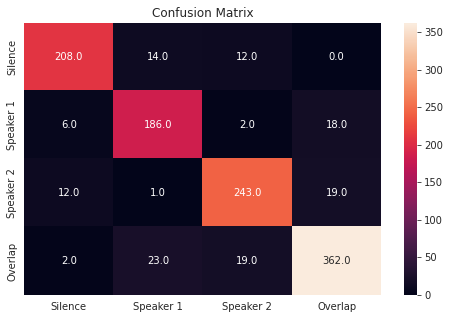

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)

sns.heatmap(metrics.confusion_matrix(true, test),
            xticklabels=["Silence", "Speaker 1", "Speaker 2", "Overlap"],
            yticklabels=["Silence", "Speaker 1", "Speaker 2", "Overlap"], annot=True, fmt=".1f")
plt.title('Confusion Matrix')

#### MLP Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, input_dim=features.shape[1], activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["acc"])

In [ ]:
history = model.fit(windowed_features, gt, batch_size=10, epochs=10, validation_split=0.2)

Epoch 1/3
451/451 [==============================] - 2s 4ms/step - loss: 0.7153 - acc: 0.4966 - val_loss: 0.7122 - val_acc: 0.4969
Epoch 2/3
451/451 [==============================] - 2s 3ms/step - loss: 0.7098 - acc: 0.4966 - val_loss: 0.7073 - val_acc: 0.4969
Epoch 3/3
451/451 [==============================] - 1s 3ms/step - loss: 0.7057 - acc: 0.4966 - val_loss: 0.7038 - val_acc: 0.4969


#### CNN Model

In [ ]:
from tensorflow import keras
import tensorflow as tf

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=1, strides=1)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="sigmoid", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

windowed_features = windowed_features.reshape(windowed_features.shape[0], windowed_features.shape[1]  * windowed_features.shape[2])
model = build_model((windowed_features.shape[1], 1), 4)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["acc"])

In [ ]:
history = model.fit(windowed_features, gt, batch_size=20, epochs=10, validation_split=0.2)

Epoch 1/10
226/226 [==============================] - 43s 168ms/step - loss: 0.4872 - acc: 0.4908 - val_loss: 0.5603 - val_acc: 0.3514
Epoch 2/10
226/226 [==============================] - 34s 149ms/step - loss: 0.4017 - acc: 0.6051 - val_loss: 0.6636 - val_acc: 0.2760
Epoch 3/10
226/226 [==============================] - 34s 149ms/step - loss: 0.3112 - acc: 0.7211 - val_loss: 0.7797 - val_acc: 0.3035
Epoch 4/10
226/226 [==============================] - 34s 151ms/step - loss: 0.2281 - acc: 0.8090 - val_loss: 1.0477 - val_acc: 0.2742
Epoch 5/10
226/226 [==============================] - 33s 148ms/step - loss: 0.1622 - acc: 0.8680 - val_loss: 1.1238 - val_acc: 0.2786
Epoch 6/10
226/226 [==============================] - 34s 148ms/step - loss: 0.1133 - acc: 0.9097 - val_loss: 1.3136 - val_acc: 0.3132
Epoch 7/10
226/226 [==============================] - 33s 148ms/step - loss: 0.0921 - acc: 0.9301 - val_loss: 1.3738 - val_acc: 0.3035
Epoch 8/10
226/226 [==============================] - 4